In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [3]:
ts_data = TimeSeriesData(250,0,10)

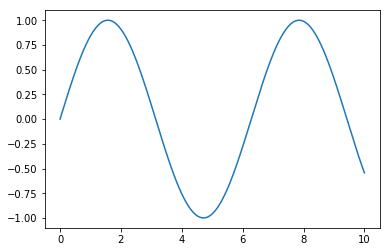

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

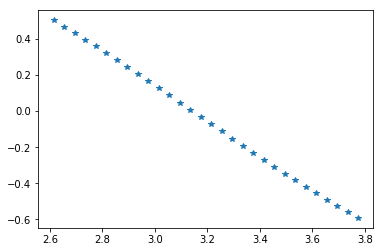

In [9]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

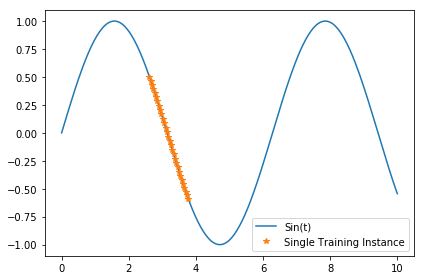

In [10]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [11]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

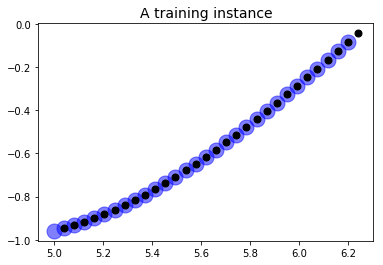

In [12]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

In [13]:
tf.reset_default_graph()

In [14]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

In [15]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [ ]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)